# GEOG696C Spatiotemporal Data Analytics: Term Project
## calcEOF_FIA.ipynb
This script reads in the FIA data - extracted in the code "extractPixelFIATimeSeries.ipynb" - and performs EOF and rotated EOF, with significance testing.

In [222]:
from pathlib import Path
import os
import sys
import pandas as pd
# import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rx
import xarray as xr
# from shapely.geometry import Polygon
# from shapely.geometry import Point
import matplotlib.pyplot as plt
# from itertools import chain
from datetime import datetime, timezone
import scipy as sp
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

## 1) Load the FIA data with xarray
8-day timesteps from 2001-2022 (ntime=985), for (1346, 1040) (nloc=1399840) 500 m resolution pixels across Bangladesh

In [30]:
# dataPath = rootPath/'Models/DeepLearning/Inference/CrossValidation/Archive/Historical/Ensemble'
dataPath = Path('C:/Users/alexsaunders/Documents/01_uoa/02_ra/01_projects/01_nip/02_hysteresis/inTmp') # local copy
dataFiles = [file for file in list(dataPath.iterdir()) if file.suffix=='.tiff']

In [31]:
print(len(dataFiles))

985


### Get the dimensions

In [5]:
# Open a single raster and get the spatial dimensions
file = dataFiles[0]
raster = rio.open(file)
rasterData = raster.read(1)
print(rasterData.shape, rasterData.shape[0]*rasterData.shape[1])

(1346, 1040) 1399840


In [6]:
# Save the dimensions we want
ntime, nrow, ncol = len(dataFiles), rasterData.shape[0], rasterData.shape[1]
print(ntime, nrow, ncol)

985 1346 1040


### Get the raster pixel data for all dates to create time series for each pixel - load with xarray

In [32]:
# Get the dates of all the raster files
imageDates=[]
# Loop through the tif files
for f, file in enumerate(dataFiles):
    # Get the data of the image
    imageDate = datetime.fromtimestamp(int(file.stem[:-3])).strftime('%Y%m%d')
    imageDates.append(imageDate)
imageDates=pd.to_datetime(imageDates)

In [35]:
# Sort the files in date order, since using their unix ms time they are not in order
sortIdx = imageDates.argsort()
dataFiles=[dataFiles[i] for i in sortIdx]
imageDates=imageDates.sort_values()

In [43]:
# Get the raster pixel coordinates
file = dataFiles[0]
with rio.open(file) as src:
    band1 = src.read(1)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    lons = np.array(xs)
    lats = np.array(ys)
    
lat=np.array([item[0] for item in lats])
lon=lons[0]

print(lat.shape, lon.shape)

(1346,) (1040,)


In [44]:
# Create empty array for storing the values
rasterDataAllDates = np.zeros([nrow, ncol, ntime])

# Loop through files and for each one, record the pixel value into an array with values for the same pixel from all other dates
# Loop through the tif files
for f, file in enumerate(dataFiles):
    # Open and get raster values
    with rio.open(file) as raster:
        # Assign raster values to array
        rasterDataAllDates[:,:,f]=raster.read(1)

In [45]:
print(rasterDataAllDates.shape)

(1346, 1040, 985)


In [46]:
# Convert to xarray data array
FIAxr = xr.DataArray(
    rasterDataAllDates,
    coords={'lat': lat, 'lon': lon, 'time': imageDates},
    dims=['lat', 'lon', 'time']
)

In [47]:
# Save as a netcdf for ease of loading in again later
outPath= rootPath/'pixelFIA/xr/'
outPath.mkdir(exist_ok=True)
FIAxr.to_netcdf(outPath/'pixelFIA.nc')

In [15]:
# Read in from nc file
# xrPath=rootPath/'pixelFIA/xr/'
# FIAxr2 = xr.open_dataarray(xrPath/'pixelFIA.nc')

In [48]:
FIAxr

<xarray.DataArray (lat: 1346, lon: 1040, time: 985)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
...
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]])
Coordinates:
  * lat      (lat) float64 26.63 26.63 26.62 26.62 ... 20.61 20.6 20.6 20.59
  * lon      (lon) float64 88.01 88.01 88.02 88.02 ... 92.66 92.67 92.67 92.68
  * time     (time) datetime64[ns] 2001-06-13 2001-06-29 ... 2022-12-30

## 2) Compute EOF on the monthly timestep data

In [49]:
FIA=FIAxr.copy()

In [50]:
# Set no data value (in raw data is -9999) to nan
noDataVal=FIA.values[0,0,0]
FIA = FIA.where(FIA!=noDataVal, np.nan)

In [51]:
FIA.shape

(1346, 1040, 985)

### Qucik plot of the data to check how it looks

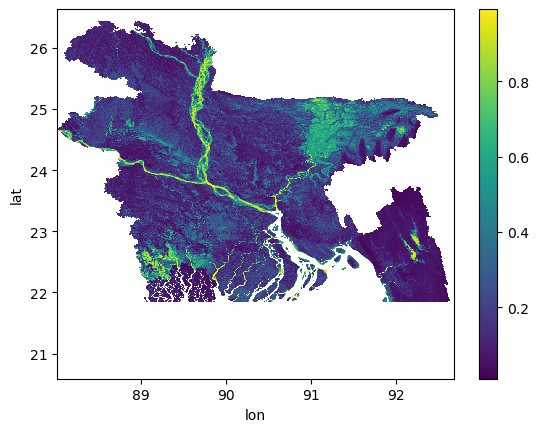

In [20]:
FIA.mean(dim="time").plot()

### Create monthly max and monsoon season max

In [52]:
# Check gaps of time data
diffs=[]
for i, date in enumerate(imageDates):
    if i!=0:
        diff = date - date0
        diffs.append(diff)
    date0=date

In [53]:
np.unique(diffs)

array([Timedelta('5 days 00:00:00'), Timedelta('6 days 00:00:00'),
       Timedelta('8 days 00:00:00'), Timedelta('16 days 00:00:00'),
       Timedelta('24 days 00:00:00'), Timedelta('32 days 00:00:00')],
      dtype=object)

In [55]:
# Use resample to get monthly
FIAMonthlyMax = FIA.resample(time='1M', skipna=True).max(dim='time')

In [62]:
# Use rolling to get annual max
FIAMonthly_ = FIAMonthlyMax.rolling(time = 12).max(skipna=True)
FIAAnnualMax = FIAMonthly_.where(FIAMonthly_.time.dt.month == 12, drop=True)

# Drop 2001 since it is an incomplete year, with data starting in June
FIAAnnualMax = FIAAnnualMax.drop_isel(time=0)

In [73]:
# Use rolling to get monsoon annual max - monsoon months are June-October inclusive i.e. 5 months
FIAMonthly_ = FIAMonthlyMax.rolling(time = 5).max(skipna=True)
FIAMonsoonMax = FIAMonthly_.where(FIAMonthly_.time.dt.month == 10, drop=True)

### Quick plots of monthly climatology

In [74]:
FIAMonthlyClim = FIA.groupby('time.month').mean(dim='time')

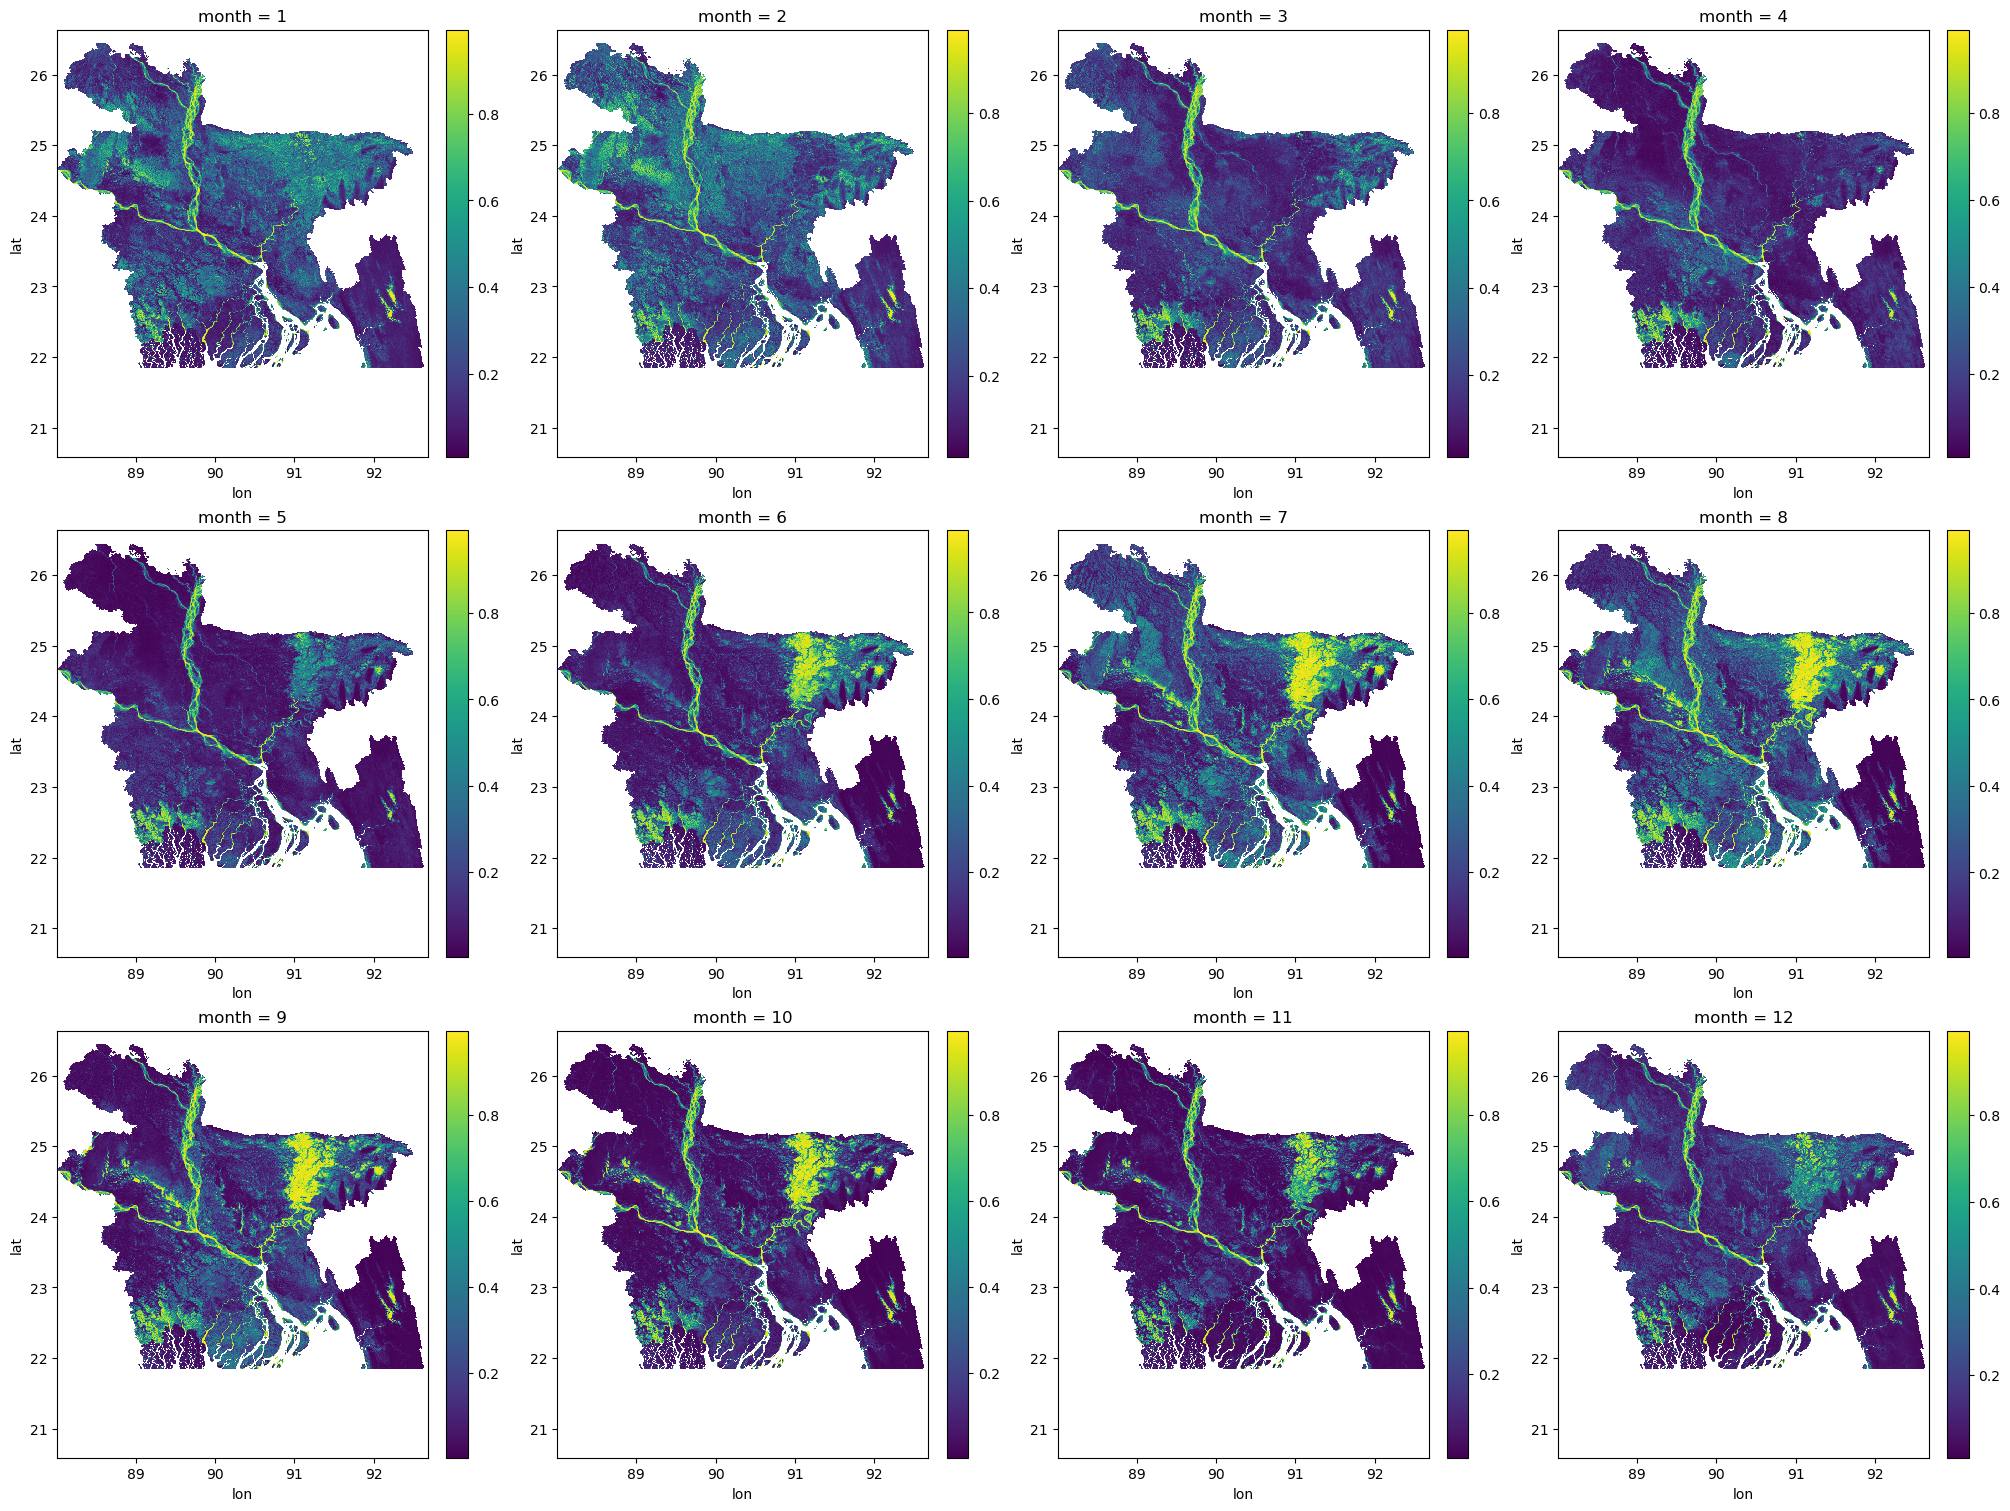

In [90]:
fig, axes = plt.subplots(3,4, figsize=(20,15), constrained_layout=True)

for i, ax in enumerate(axes.ravel()):
    FIAMonthlyClim[:,:,i].plot(ax=ax)

### Quick plots of annual monsoon max

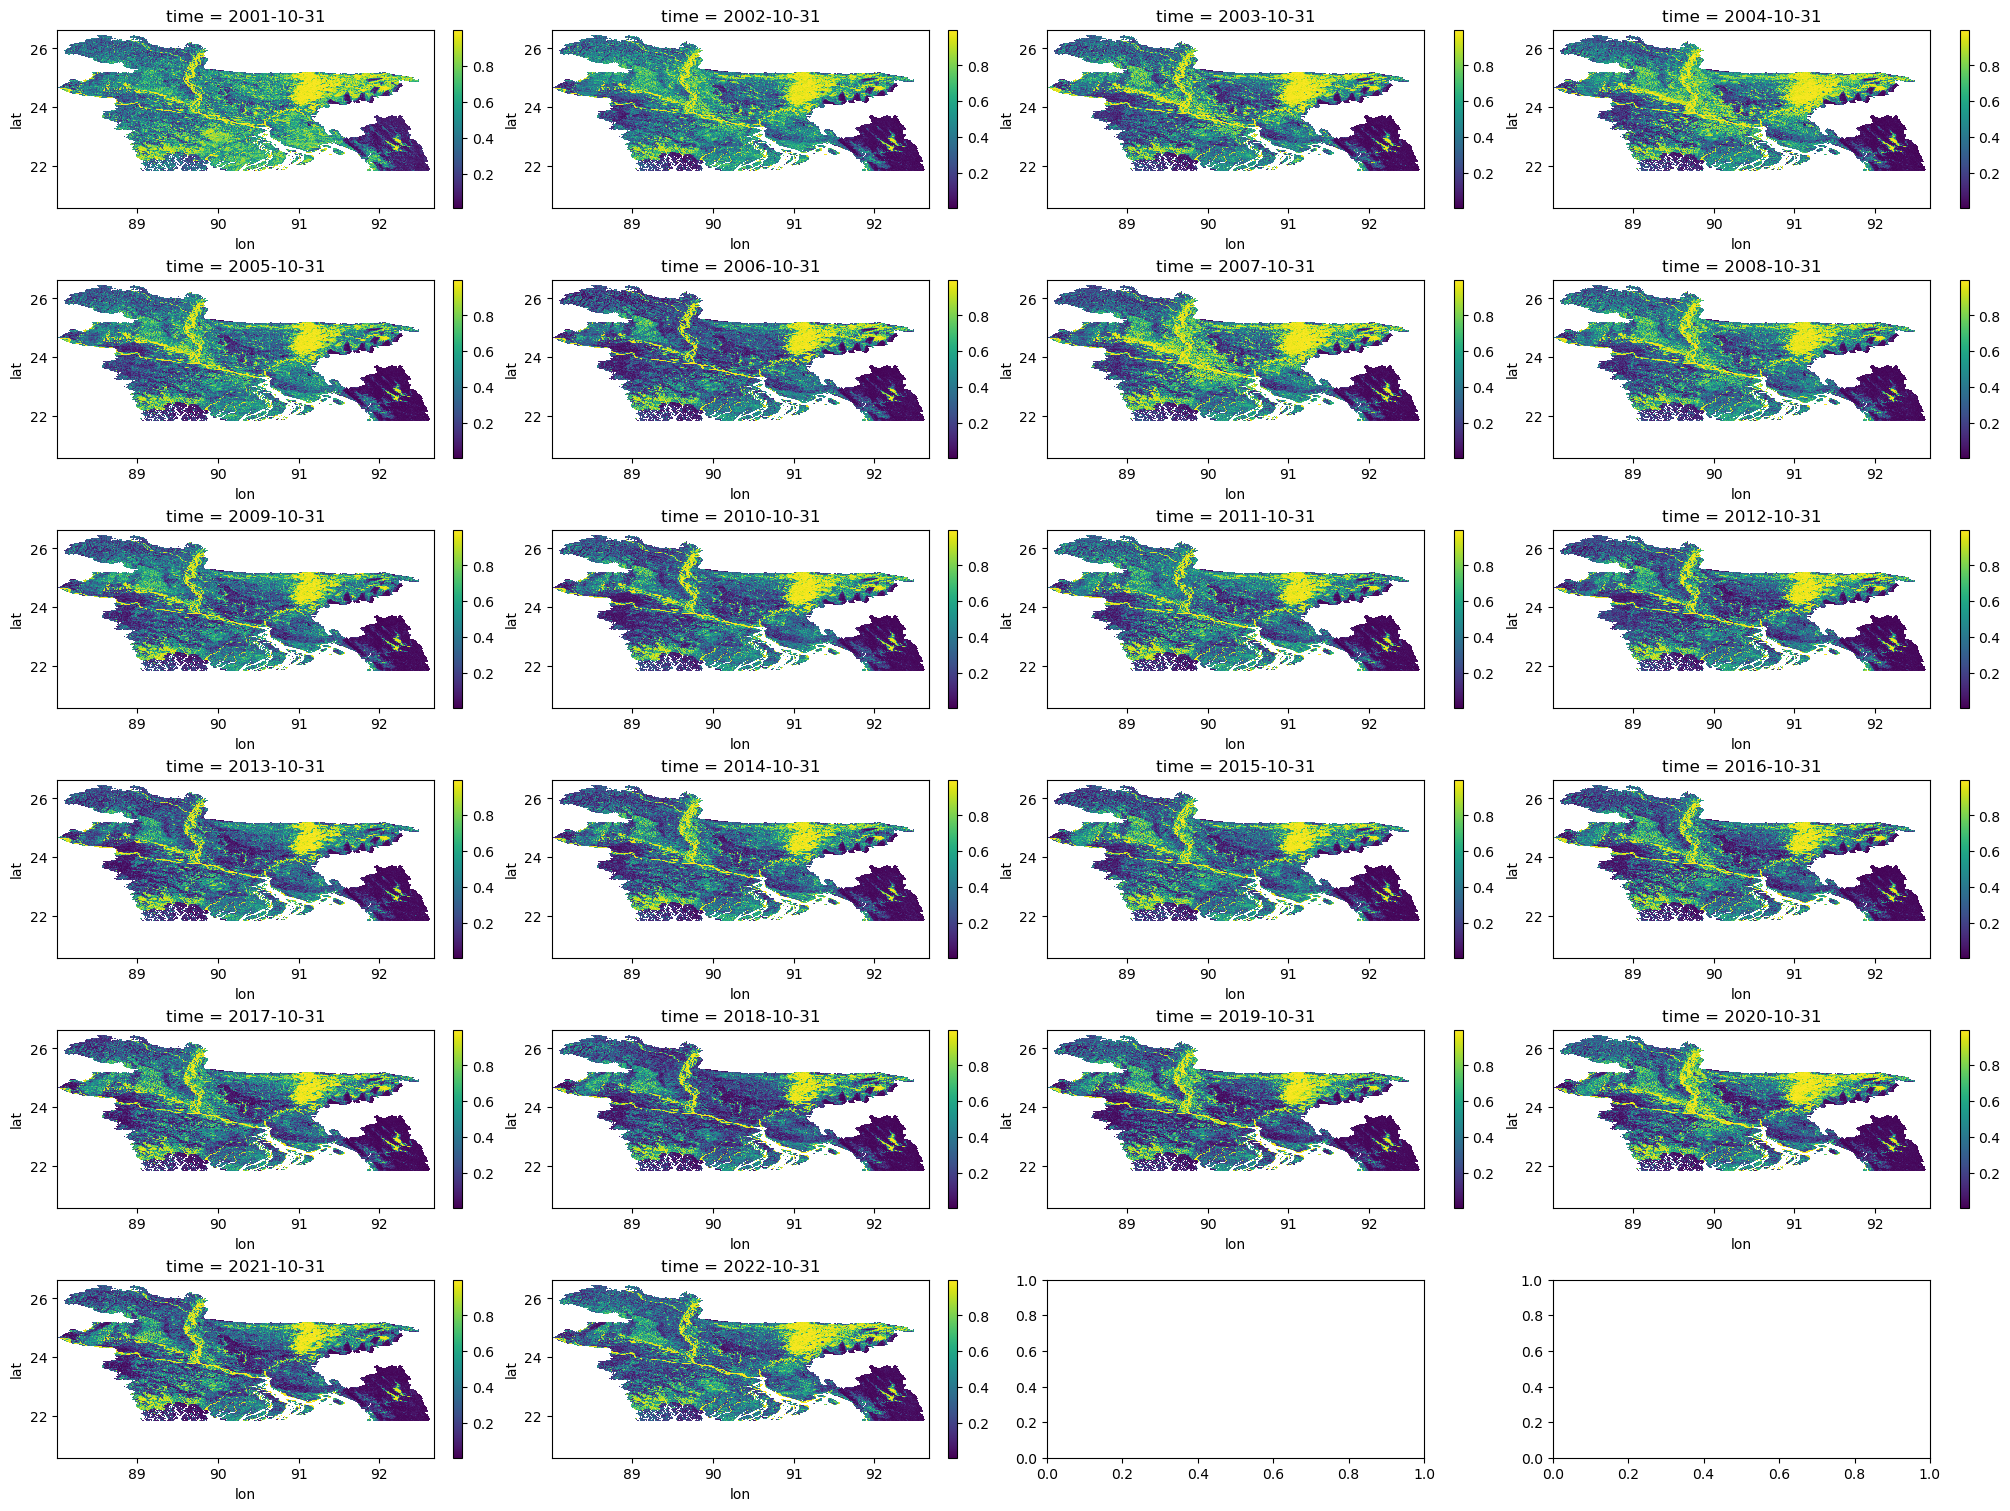

In [94]:
fig, axes = plt.subplots(6,4, figsize=(20,15), constrained_layout=True)

for i, ax in enumerate(axes.ravel()[0:len(FIAMonsoonMax.time)]):
    FIAMonsoonMax[:,:,i].plot(ax=ax)

### Reshape and normalize

In [96]:
# Reshape from 3D (time, lat, lon) to 2D (time, locs)
ntime, nrow, ncol = FIAMonsoonMax.shape[2], FIAMonsoonMax.shape[0], FIAMonsoonMax.shape[1]
nloc=nrow*ncol
FIA_2D = np.array(FIAMonsoonMax).reshape(ntime, nloc, order='F')

In [97]:
print(FIA_2D.shape)

(22, 1399840)

In [110]:
# Remove locs with missing values i.e. only keep pixels which have zero NA values at all timesteps
noMissing = ~np.isnan(FIA_2D).any(axis=0)
FIA_2D = FIA_2D[:,noMissing]

In [112]:
print(FIA_2D.shape)

(22, 522794)


In [120]:
# Subtract mean and divide by standard deviation at each pixel
FIAAnom = (FIA_2D - FIA_2D.mean(axis=0)) / FIA_2D.std(axis=0)

In [122]:
FIAAnom

array([[-1.78834702, -1.34376662,  0.15696369, ...,  1.23109427,
         3.25716995,  0.5388495 ],
       [-1.25803441, -1.64991533, -0.22417205, ...,  0.15114219,
         1.93503439,  0.32382726],
       [-0.13421194, -1.40976296, -0.80796166, ...,  0.70199349,
         0.79392546, -0.51716639],
       ...,
       [ 1.23864368,  1.29737714,  0.987725  , ..., -0.30229395,
         0.39592207, -0.45597256],
       [ 0.61039083,  1.77431603,  2.24971529, ..., -0.70423985,
         0.17850463, -0.32352718],
       [-0.05410867,  1.80255401,  2.35350856, ..., -1.80848716,
        -0.74410851, -0.4505221 ]])

In [123]:
FIAAnom.shape

(22, 522794)

### Quick plot of the pixel anomalies in the monsoon max data

In [128]:
# Empty 3D matrix for taking the values
FIA_3D=np.ones([ntime, nrow*ncol]) * np.NaN
FIA_3D[:, noMissing]=FIAAnom
FIA_3D=FIA_3D.reshape([ntime, nrow, ncol], order='F')

In [141]:
# Empty 3D matrix for taking the values
FIA_3D=np.ones([ntime, nrow*ncol]) * np.NaN
FIA_3D[:, noMissing]=FIA_2D
FIA_3D=FIA_3D.reshape([ntime, nrow, ncol], order='F')

In [142]:
FIA_3D.shape

(22, 1346, 1040)

In [144]:
np.nanmax(FIA_3D[i,:,:])

0.9996867179870605

### Perform EOF

In [159]:
import gc
gc.collect()

1551

In [161]:
# Calculate covariance matrix of the anomalies- too computationally expensive!
# C = np.cov(FIAAnom, rowvar=False, ddof=1)
#Unable to allocate 1.99 TiB for an array with shape (522794, 522794) and data type float64

In [192]:
# Perform SVD on the data (not the covariance matrix)
U, S, Vt = sp.sparse.linalg.svds(FIAAnom, k=21)

In [193]:
# Sort the eigenmodes
sort_index = np.argsort(S)[::-1]
S = S[sort_index]
U = U[:,sort_index]
V = Vt.T[:,sort_index]

In [199]:
S.shape[0]

21

In [194]:
# Create the PCs time series
pcs = FIAAnom @ V

In [200]:
# Create the EOFs with dimensions of the original data
eofs = np.full((nrow*ncol, S.shape[0]), np.nan) 
eofs[noMissing,:] = V
eofs = eofs.reshape([nrow, ncol, S.shape[0]], order='F')

In [202]:
print(eofs.shape)

(1346, 1040, 21)


In [203]:
print(pcs.shape)

(22, 21)


### Plot the PCs

In [209]:
pcs[:,0].shape

(22,)

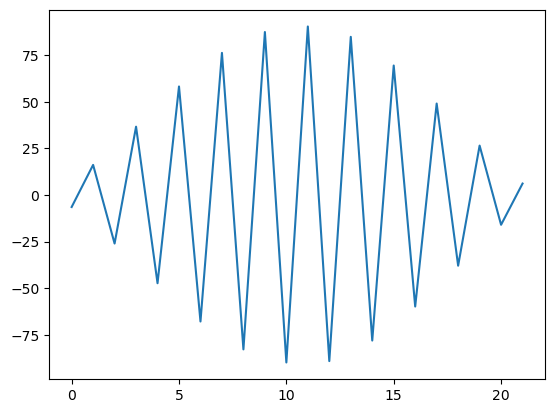

In [216]:
plt.plot(pcs[:,20])

### Plot the EOFs

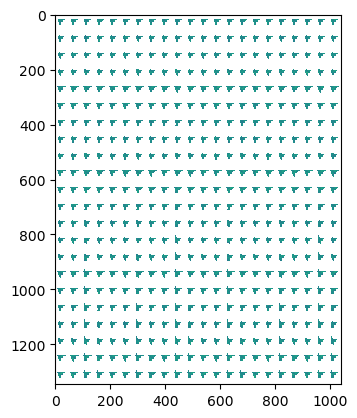

In [221]:
plt.imshow(eofs[:,:,0])

In [244]:
eofs[:,:,0].shape

(1346, 1040)

In [246]:
FIA.lat.shape

(1346,)

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\matplotlib\axes\_axes.py:6679: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\matplotlib\axes\_axes.py:6680: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([[ 4.,  2.,  2., ...,  0.,  0.,  0.],
        [ 7., 10., 14., ...,  7.,  7.,  1.],
        [ 1., 10., 12., ..., 15.,  8.,  0.],
        ...,
        [ 3., 18., 23., ..., 26., 23.,  0.],
        [ 3.,  9., 21., ..., 17., 12.,  3.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.]]),
 array([-2.95456411e-03, -2.36149292e-03, -1.76842174e-03, -1.17535056e-03,
        -5.82279373e-04,  1.07918097e-05,  6.03862993e-04,  1.19693418e-03,
         1.79000536e-03,  2.38307654e-03,  2.97614773e-03]),
 <a list of 1040 BarContainer objects>)

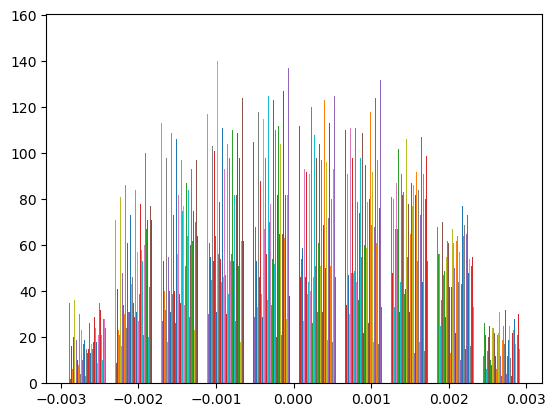

In [247]:
plt.hist(eofs[:,:,0])

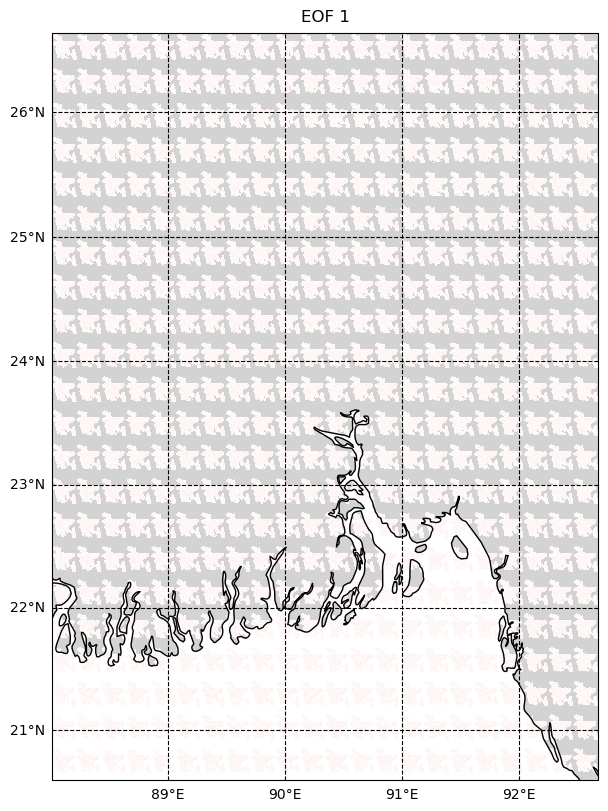

In [248]:
# levels = np.linspace(-0.05, 0.05, 51)

fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=90)})
fig.suptitle('EOF 1')

# EOF1
# ax=axes[0]
# ax.set_title('EOF1', fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_extent([FIA.lon.min().values, FIA.lon.max().values, FIA.lat.min().values, FIA.lat.max().values], crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
eof1Plot = ax.contourf(FIA.lon, FIA.lat, eofs[:,:,0], cmap='bwr', transform=ccrs.PlateCarree(), vmin=-0.05, vmax=0.05)#, levels=levels,vmin=-0.05, vmax=0.05,) 
# cb1 = plt.colorbar(eof1Plot, orientation='vertical', ticks=np.linspace(-0.05, 0.05, 11))
